# Part 2: MOSAIKS
To predict the relative wealth of the people in a given area, we will start with a geospatial foundation model called MOSAIKS. MOSAIKS uses random convolutional features to extract n features from a satellite image, each corresponding to a given random filter. 

MULTI-TASK OBSERVATION USING SATELLITE IMAGERY & KITCHEN SINKS
Nature Paper: https://www.nature.com/articles/s41467-021-24638-z
Website with API: https://api.mosaiks.org/portal/index/

## Environment Setup

In [ ]:
# install any libraries that are missing
# !pip install geopandas
# !pip install lonboard

In [14]:
# for fetching data
import os
import requests
from tqdm import tqdm

# for data processing
import zipfile
import glob
import pandas as pd
import numpy as np
import geopandas as gpd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from lonboard import viz, Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.sequential import YlGnBu_9

# for regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# set the random seed for reproducibility
np.random.seed(42)

print("imported")


imported


In [5]:
# configure parameters
decimal_place = 0.25 # spatial resolution of the mosaiks embeddings in degrees of lat/long
base_path = f"/Users/isaiah/code/ai4good/data/wk5/mosaiks{decimal_place}/"
zip_path = f"{base_path}global_{decimal_place}.zip"
mosaiks_embeddings_path = f"{base_path}coarsened_global_dense_grid_decimal_place={decimal_place}_GHS_pop_weight=True.csv"
labels_path = f"{base_path}dhs_final_labels_centered.csv"
merge_path = f"{base_path}dhs_final_labels_centered_with_mosaiks.csv"

In [ ]:
# which data resolution you want as a fraction of a degree
# use 0 for 1 degree or 0.25 for 1/4 degree
decimal_place = 0.25

# Cookie for authentication
COOKIE = {
    "csrftoken": "I9x2jvGGE4se3MBa9moavDtC9o8YEgaA4Rup5ijhHJjCTRn0qRpHGJW06XG0SooG",
    "sessionid": "y44nlmh7rjrqvvxj902jc8pmw918m1p7",
}


# Destination directory
os.makedirs(base_path, exist_ok=True)  # Ensure the directory exists

# Function to download a file with progress bar
def download_file(url, filename):
    response = requests.get(url, cookies=COOKIE, stream=True, verify=False)
    # handle request
    if response.status_code == 200:
        total_size = int(response.headers.get("content-length", 0))
        with open(filename, "wb") as f, tqdm(
            desc=os.path.basename(filename),
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(1024):
                f.write(chunk)
                bar.update(len(chunk))
        print(f"✅ Downloaded: {filename}")
    else:
        print(f"❌ Failed to download {url} (Status {response.status_code})")

# Download each file
# Base URL for file downloads
URL = f"https://api.mosaiks.org/portal/download_grid_file/coarsened_global_dense_grid_decimal_place=0.25_GHS_pop_weight=True.zip"
print(f"📥 Downloading {URL}...")
download_file(URL, zip_path)

In [ ]:
decimal_place = 0.25

# Define the directory containing the zip files
path = f"/Users/isaiah/code/ai4good/data/wk5/mosaiks{decimal_place}"
# Loop through all zip files in the directory
for zip_file in glob.glob(os.path.join(path, "*.zip")):
    # Open the zip file
    with zipfile.ZipFile(zip_file, "r") as z:
        # Extract all the contents into the extraction directory
        z.extractall(path)
        print(f"Extracted {zip_file} to {path}")

### Prepare Data to Merge with MOSAIKS Embeddings
Now we need to match up our locations with the MOSAIKS locations.

In [107]:
# Load dataset
df = pd.read_csv("/Users/isaiah/code/ai4good/data/wk5/dhs_final_labels.csv")

# Assign coordinates to nearest tile centroid

# for 1 degree
if decimal_place == 0:
    df["Lon"] = round(round(df["lon"] + 0.5, 0) - 0.5, 1)
    df["Lat"] = round(round(df["lat"] + 0.5, 0) - 0.5, 1)
# for 1/4 degree
if decimal_place == 0.25:
    df["Lon"] = round((round(df["lon"]*4 + 0.5, 0) - 0.5)/4, 3)
    df["Lat"] = round((round(df["lat"]*4 + 0.5, 0) - 0.5)/4, 3)

# drop rows that have a NaN for asset_index
df = df.dropna(subset=["asset_index"])

# keep just one row for every unique Lat, Lon combination
before_len = len(df)
df = df.drop_duplicates(subset=["Lat", "Lon"], keep="first")
print(f"Started with {before_len} rows, now have {len(df)} rows")

# Convert to GeoDataFrame
df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Lon"], df["Lat"]), crs="EPSG:4326")

# Write to CSV
df_gdf.to_csv(f"/Users/isaiah/code/ai4good/data/wk5/mosaiks{decimal_place}/dhs_final_labels_centered.csv", index=False)

# visualize it, it should appear gridded to 1 degree now
viz(df_gdf)

Started with 86936 rows, now have 15725 rows


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

### Merge Embeddings with Labels
Now that the data points have been moved to the centroids of the clusters, we can merge the embeddings with the labels.

In [6]:
# read in the MOSAIKS embeddings
mosaiks = pd.read_csv(mosaiks_embeddings_path)
df = pd.read_csv(labels_path)

# merge the two dataframes on the Lat, Lon columns from the labels and the lat, lon columns from the mosaiks
mosaiks = mosaiks.rename(columns={"lat": "Lat", "lon": "Lon"})
df_merged = df.merge(mosaiks, on=["Lat", "Lon"], how="left")

# save this as a csv
df_merged.to_csv(merge_path, index=False)

# inspect the data
df_merged.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,0.404039,0.273514,0.791418,0.682969,0.309669,1.118469,1.833150,0.696552,0.658404,0.193666
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,0.330853,0.190949,0.651737,0.483889,0.257195,1.006640,1.774877,0.650429,0.494067,0.154435
2,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,0.526517,0.313641,0.959126,0.682735,0.432498,1.417022,2.393527,0.873952,0.792562,0.203758
3,AL-2008-5#-00000016,AL,2008,41.491808,20.192569,18.0,3.124491,18.0,5.000000,18.0,...,0.276719,0.195111,0.645757,0.450602,0.225587,0.831416,1.584741,0.543849,0.416042,0.153830
4,AL-2008-5#-00000017,AL,2008,41.538256,20.274292,19.0,2.966058,19.0,4.789474,19.0,...,0.347737,0.240502,0.734483,0.529795,0.288115,1.008829,1.819084,0.737178,0.551874,0.203878


## Prep Data for Predicting Wealth Using Regression
1. Drop any rows with missing label values
2. Split into test / validation / train datasets

In [6]:
# read in the data
df = pd.read_csv(merge_path)

# keep just the columns we need
df = df[[col for col in df.columns if col.startswith("X_")] + ["asset_index"]]
# check for NaNs
print("Number of NaNs in df: ", df.isna().sum())
# drop rows with NaNs
df = df.dropna()
# check the shape again
print("Shape of df: ", df.shape)

# split the data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# split the test set into val and test sets
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
# check the shapes of the data
print("Shape of df_train: ", df_train.shape)
print("Shape of df_val: ", df_val.shape)
print("Shape of df_test: ", df_test.shape)


# separate the data into X and y
y_train = df_train["asset_index"]
y_val = df_val["asset_index"]
y_test = df_test["asset_index"]

# x is all the data in columns with names formatted like "X_1"
X_train = df_train[[col for col in df.columns if col.startswith("X_")]]
X_val = df_val[[col for col in df.columns if col.startswith("X_")]]
X_test = df_test[[col for col in df.columns if col.startswith("X_")]]


/var/folders/9j/vk59njf93797lv4t6hpkhq080000gn/T/ipykernel_46996/2872446262.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(merge_path)


Number of NaNs in df:  X_0            3
X_1            3
X_2            3
X_3            3
X_4            3
              ..
X_3996         3
X_3997         3
X_3998         3
X_3999         3
asset_index    0
Length: 4001, dtype: int64
Shape of df:  (15722, 4001)
Shape of df_train:  (12577, 4001)
Shape of df_val:  (1572, 4001)
Shape of df_test:  (1573, 4001)


## Run Linear Classifier using Ridge Regression
Now that we have our embeddings and our labels, we can run a linear classifier on top of the embeddings to see how well each model does at predicting poverty and wealth. We will use Ridge regression to do this, since it is a linear model that can handle high dimensional data well. It uses L2 regularization to prevent overfitting, penalizing large weights. You can learn more about it in [this Medium post](https://medium.com/@msoczi/ridge-regression-step-by-step-introduction-with-example-0d22dddb7d54) or in this tutorial from [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/).

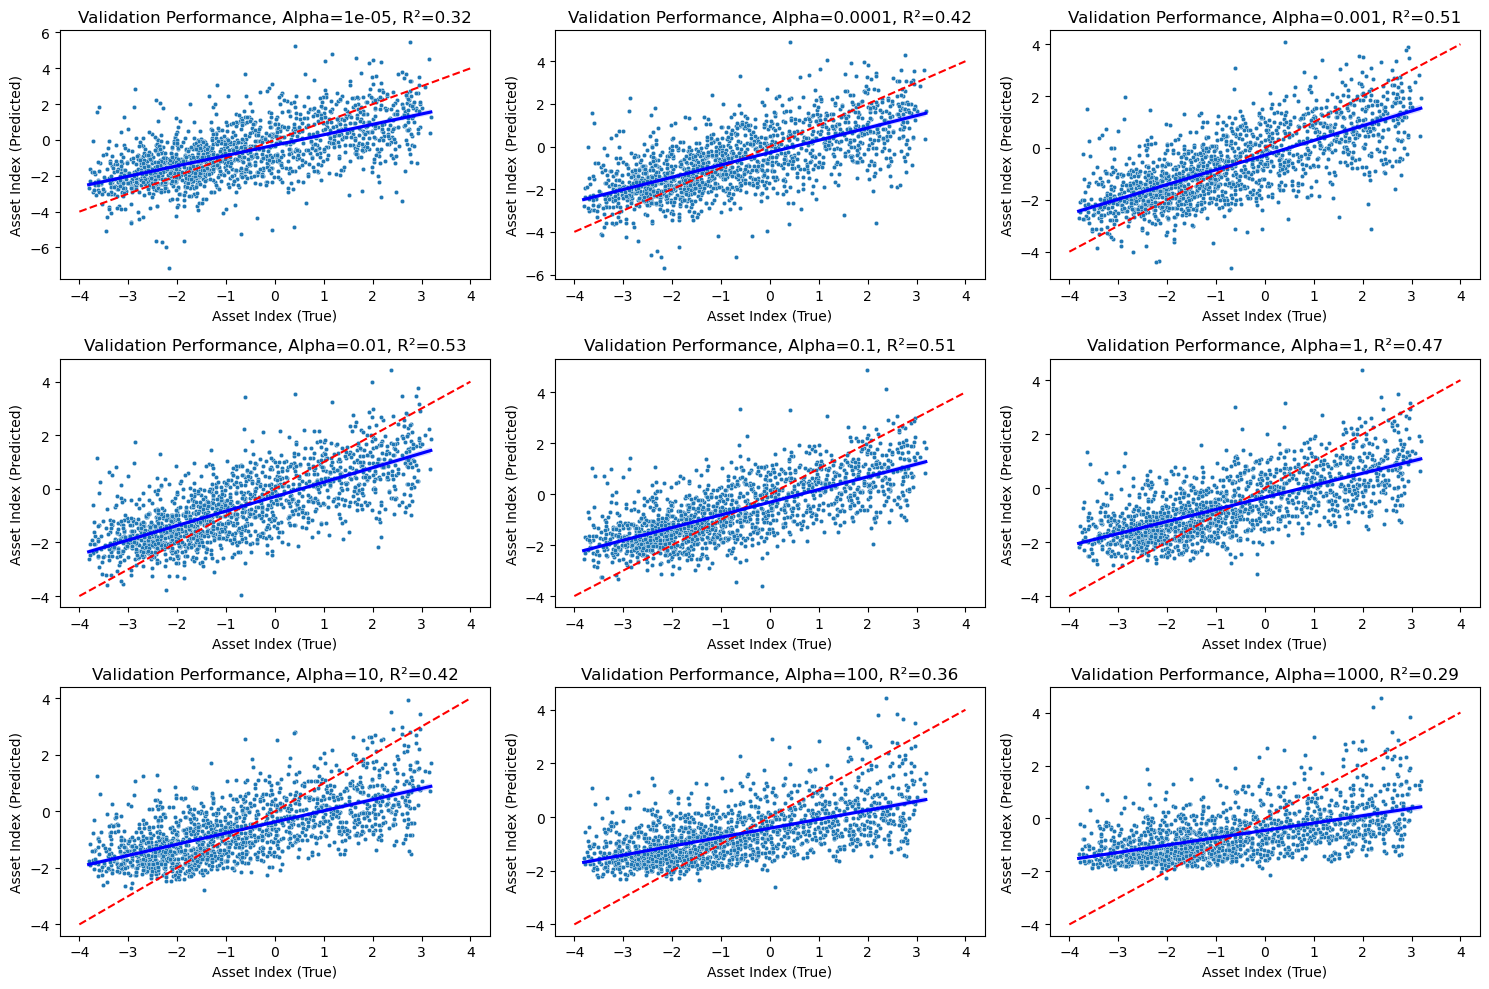

In [14]:
# Define alpha values to loop over
alpha_values = [10**i for i in range(-5, 4)]  # Corrected alpha values from 0.001 to 1000

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, alpha in enumerate(alpha_values):
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    
    # Create scatter plot using Seaborn
    sns.scatterplot(x=y_val, y=y_pred, ax=axes[i], s=10)
    axes[i].plot([-4, 4], [-4, 4], "r--")  # 45-degree line
    
    # Fit a regression line with confidence interval
    sns.regplot(x=y_val, y=y_pred, ax=axes[i], scatter=False, ci=95, line_kws={"color": "blue"})
    
    axes[i].set_title(f"Validation Performance, Alpha={alpha}, R²={r2:.2f}")
    axes[i].set_xlabel("Asset Index (True)")
    axes[i].set_ylabel("Asset Index (Predicted)")

plt.tight_layout()
plt.show()

We can see that the top performing value for alpha on the validation dataset is 0.01. For a final test of the model, let's run this regression model trained on the test data, tuned on the validation, and see how well it performs on the test data.

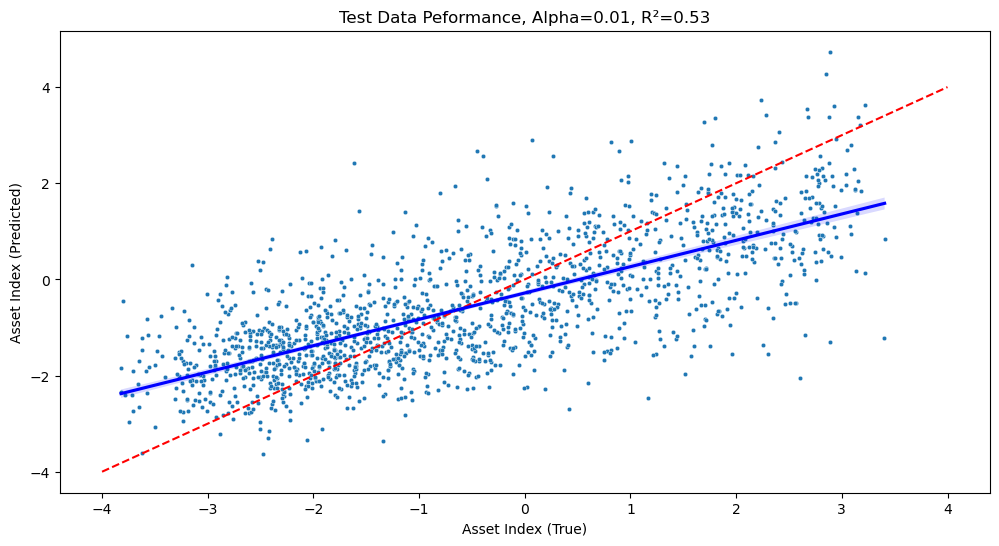

In [19]:
# Select the best alpha value from the validation data
alpha = 0.01

# Train Ridge regression model on training data
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
coefficients = ridge_model.coef_

# Use coefficients from training for inference on test data
y_pred = X_test @ coefficients + ridge_model.intercept_
r2 = r2_score(y_test, y_pred)

# Create scatter plot using Seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred, s=10)
plt.plot([-4, 4], [-4, 4], "r--")  # 45-degree line

# Fit a regression line with confidence interval
sns.regplot(x=y_test, y=y_pred, scatter=False, ci=95, line_kws={"color": "blue"})

plt.title(f"Test Data Peformance, Alpha={alpha}, R²={r2:.2f}")
plt.xlabel("Asset Index (True)")
plt.ylabel("Asset Index (Predicted)")

plt.show()


## Global Wealth Prediction
Now that we have a model that can predict wealth, let's use it to predict wealth across the entire globe. We will use the MOSAIKS API to get embeddings for the entire world, and then use our model to predict wealth for each location.

In [8]:
# configure parameters
base_path = f"/Users/isaiah/code/ai4good/data/wk5/mosaiks1.0/"
mosaiks_embeddings_path = f"{base_path}coarsened_global_dense_grid_decimal_place=0_GHS_pop_weight=True.csv"

# Retrain Ridge regression model on training data
print("Retraining ridge model on training data...")
alpha = 0.01
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
coefficients = ridge_model.coef_

print("reading in the global dataset...")
# read in the global dataset of mosaiks embeddings
mosaiks = pd.read_csv(mosaiks_embeddings_path)
print("read in dataset")

lat_global = mosaiks["lat"]
lon_global = mosaiks["lon"]
# pull out the embeddings from the dataframe, columns that begin with "X_"
X_global = mosaiks.drop(columns=["lat", "lon", "continent"])
print("extracted just embeddings")
# Select the best alpha value from the validation data
alpha = 0.01
# Train Ridge regression model on training data
coefficients = ridge_model.coef_
print("fitted ridge model to training data")

# Use coefficients from training for inference on test data
print("running inference on the global data...")
y_pred_global = X_global @ coefficients + ridge_model.intercept_
print("inference complete")


Retraining ridge model on training data...
reading in the global dataset...
read in dataset
extracted just embeddings
fitted ridge model to training data
running inference on the global data...
inference complete


Visualize the global predictions.

In [24]:
# Merge predictions with lat/lon, name prediction column "pred"
df_global = pd.concat([lat_global, lon_global, pd.Series(y_pred_global)], axis=1)
df_global.columns = ["lat", "lon", "pred"]

# Convert to GeoDataFrame
gdf_global = gpd.GeoDataFrame(df_global, geometry=gpd.points_from_xy(df_global["lon"], df_global["lat"]), crs="EPSG:4326")

# Normalize predictions for color mapping
pred = gdf_global["pred"].values
pred_min = np.percentile(pred, 5)
pred_max = np.percentile(pred, 95)
pred_norm = (pred - pred_min) / (pred_max - pred_min)

# Create ScatterplotLayer and map
layer = ScatterplotLayer.from_geopandas(
    gdf_global,
    get_fill_color=apply_continuous_cmap((1-pred_norm), YlGnBu_9, alpha=0.8),
    get_radius=70000,  # Adjust radius for better visualization
    pickable=True,    # Enable interactivity
)

# Render the map
m = Map(layer)
m

Map(layers=[ScatterplotLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x31bb909a0>
[
  [
    4…

## Assignment
1. Answer the following questions based on the regression figures above:
    - What's going on with the small alpha values? Why are most data points squished up towards the top? Why is there such a strong outlier?
    - What do you think is going on with the large alpha values? Why does the R-squared value decrease again? 
    - The red line shows a 45-degree line of a theoretical perfect fit. The blue line shows an approximation of the actual fit. Why is the blue line consistently flatter than the red line? What does this mean for our model? How could we improve that?

2. What do you make of our global inference map

2. Pick another variable from the SustainBench poverty dataset and repeat the analysis above. Do you see an even stronger correlation with MOSAIKS embeddings? A weaker one? Why do you think that is?

## Bonus Assignment: Geospatial Errors
Associate the errors in the model above with the original geospatial datapoints in the SustainBench dataset and plot them on a map. Do you see any patterns? Are there any areas of the map that perform worse than others? If so, what do you think you could do to reduce the geographic bias of the model?

In [10]:
# export the lat lon pairs from the global dataset
df_global[['lon','lat']].to_csv(f"/Users/isaiah/code/ai4good/data/wk5/mosaiks1.0/global_lat_lon_pairs.csv", index=False)